# HW3 - CS391L Machine Learning WB (Spring 23)
Due Date: 29th March 23, 11:59 PM

*Submission by - Sidharth Nair (sn25377)*

\*\***Refer to the problem staement pdf for question descriptions**\*\*

### **Answer1**

Since the data is composed of two classes, we can use SVMs to try to solve for a decision boundary. However, because the data is not linearly separable, we will want to use the kernel trick to expand the number of features such that the data *in the new feature space* becomes linearly separable. For this problem, we will use the radial-basis/gaussian kernel. This kernel is a good choice for this problem since it will map the inner circle to higher values in the new feature dimension than the outer circle, which will allow us to separate the data by a hyperplane using SVMs. Note that we will need to adjust the width parameter using the radii of the two classes so that the kernel decision boundary between the two classes is more clearly defined.

### **Answer2**

### Imports

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

### Data Loading

In [3]:
trn_R = np.load('dataset/trn_R.npy')
val_R = np.load('dataset/val_R.npy')

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, R):
        self.R = R
        self.N = R.shape[0]
        self.M = R.shape[1]
        self.I = np.nonzero(R)
        self.n = len(self.I[0])

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        i = self.I[0][idx]
        j = self.I[1][idx]
        return (i, j, self.R[i, j])

In [5]:
trn_dataset = Dataset(trn_R)
val_dataset = Dataset(val_R)

trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=2048, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2048, shuffle=False)

In [6]:
# evaluate RMSE
def eval(net, loader):
    net.eval()
    with torch.no_grad():
        se = 0 # sum of squared errors
        for b in loader:
            y = net(b)
            se += F.mse_loss(y.squeeze(), b[2].float(), reduction='sum').item()
        rmse = np.sqrt(se/loader.dataset.n)
    return rmse

In [7]:
class Net(nn.Module):
    def __init__(self, num_users, num_movies, emb_dim=10, hidden_dim=100):
        super().__init__()
        # TODO: define your network here
        self.emb_users = nn.Embedding(num_users, emb_dim)
        self.emb_movies = nn.Embedding(num_movies, emb_dim)
        self.fc = nn.Linear(2 * emb_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
        self.double()

    def forward(self, b):
        # TODO: define your forward pass here
        x = torch.cat([self.emb_users(b[0]), self.emb_movies(b[1])], dim=1)
        x = torch.tanh(self.fc(x))
        x = torch.relu(self.linear(x))
        return x.squeeze()

#### Define your network, loss function and optimizer

In [8]:
def init_network(num_users, num_movies, emb_dim=10, hidden_dim=100, lr=10e-3):
    net = Net(num_users, num_movies, emb_dim, hidden_dim)
    loss = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    return net, loss, optimizer

#### Implement the training loop function

In [9]:
def train(net, loss_fn, optimizer, trn_loader, num_epochs=20, batch_size=2048):
    # Put the network in training mode
    net.train()

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        t = tqdm(trn_loader, desc='Epoch: 0, Loss: 0.0', leave=True, position=0)
        
        for i, data in enumerate(t):
            # get the inputs
            b = data
            
            # TODO: zero the parameter gradients + forward pass + loss computation + backward pass + weight update
            optimizer.zero_grad()
            
            outputs = net.forward(b)
            loss = loss_fn(outputs, b[2])
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            t.set_description(f'Epoch: {epoch}/{num_epochs}, Loss: {running_loss/(i+1):.4f}', refresh=True)

In [10]:
num_users = trn_R.shape[0]
num_movies = trn_R.shape[1]

In [10]:
net, loss_fn, optimizer = init_network(num_users, num_movies)
train(net, loss_fn, optimizer, trn_loader)
trn_rmse = eval(net, trn_loader)
val_rmse = eval(net, val_loader)
print(f'Training Data RMSE: {trn_rmse}, Validation Data RMSE: {val_rmse}')

Epoch: 19/20, Loss: 1.1671: 100%|██████████| 108/108 [00:01<00:00, 60.71it/s]


Training Data RMSE: 1.0800378970649809, Validation Data RMSE: 1.0967712948369859


#### Perform hyperparameter tuning

In [14]:
def plot(x, x_label, trn_rmse, val_rmse):
    plt.plot(np.asarray(x).astype('str'), trn_rmse, label="train")
    plt.plot(np.asarray(x).astype('str'), val_rmse, label="validation")
    plt.legend()
    plt.title(f'{x_label} vs RMSE')
    plt.xlabel(x_label)
    plt.ylabel("RMSE")
    plt.show()

In [15]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1.0]
trn_rmse = []
val_rmse = []

for lr in lrs:
    net, loss_fn, optimizer = init_network(num_users, num_movies, lr=lr)
    train(net, loss_fn, optimizer, trn_loader)
    trn_rmse.append(eval(net, trn_loader))
    val_rmse.append(eval(net, val_loader))

Epoch: 19/20, Loss: 1.0887: 100%|██████████| 108/108 [00:01<00:00, 71.03it/s]
Epoch: 0/20, Loss: 171140408852808801270168182080585279924519520416917708655371829790949915753986493793472907391557547635884164382167001524222329882819799956950013182356312385506954256083386089343622811534440064166664418898472475820032.0000: 100%|██████████| 108/108 [00:01<00:00, 62.34it/s]
Epoch: 19/20, Loss: nan: 100%|██████████| 108/108 [00:01<00:00, 78.14it/s]


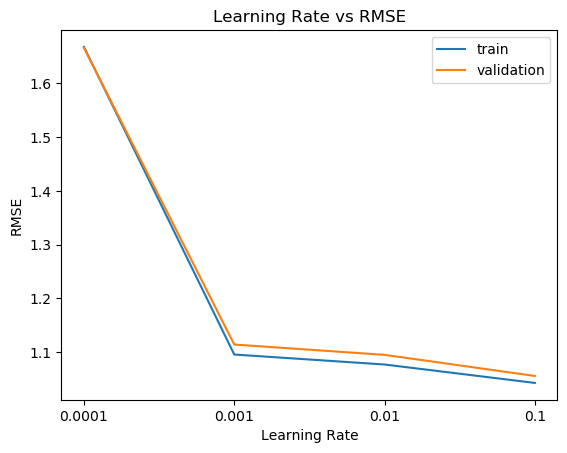

Optimal LR: 0.1 Optimal RMSE: 1.055647933948865


In [18]:
plot(lrs, "Learning Rate", trn_rmse, val_rmse)
optimal_lr = None
optimal_lr_rmse = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_lr_rmse > val_rmse[i]:
        optimal_lr = lrs[i]
        optimal_lr_rmse = val_rmse[i].item()
print("Optimal LR:", optimal_lr, "Optimal RMSE:", optimal_lr_rmse)

In [29]:
emb_dims = [10, 20, 50, 100, 200, 500]
trn_rmse = []
val_rmse = []

for emb_dim in emb_dims:
    net, loss_fn, optimizer = init_network(num_users, num_movies, lr=0.1, emb_dim=emb_dim)
    train(net, loss_fn, optimizer, trn_loader)
    trn_rmse.append(eval(net, trn_loader))
    val_rmse.append(eval(net, val_loader))

Epoch: 19/20, Loss: 0.6914: 100%|██████████| 108/108 [00:06<00:00, 15.50it/s]


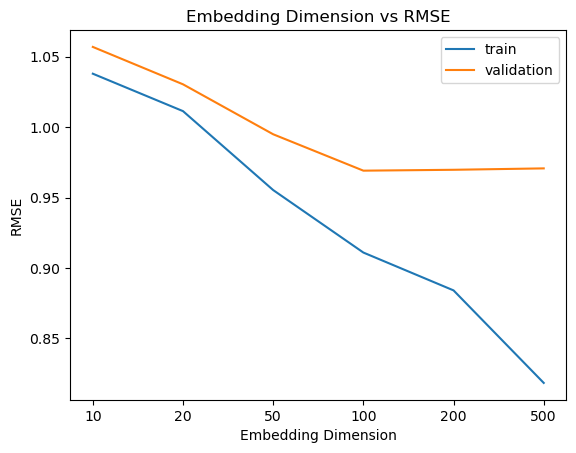

Optimal Embedding Dimension: 100 Optimal RMSE: 0.969106068723943


In [30]:
plot(emb_dims, "Embedding Dimension", trn_rmse, val_rmse)
optimal_emb_dim = None
optimal_emb_dim_rmse = None
for i in range(len(emb_dims)):
    if optimal_emb_dim is None or optimal_emb_dim_rmse > val_rmse[i]:
        optimal_emb_dim = emb_dims[i]
        optimal_emb_dim_rmse = val_rmse[i].item()
print("Optimal Embedding Dimension:", optimal_emb_dim, "Optimal RMSE:", optimal_emb_dim_rmse)

In [34]:
hidden_dims = [5, 10, 20, 50, 100, 200]
trn_rmse = []
val_rmse = []

for hidden_dim in hidden_dims:
    net, loss_fn, optimizer = init_network(num_users, num_movies, lr=optimal_lr, emb_dim=optimal_emb_dim, hidden_dim=hidden_dim)
    train(net, loss_fn, optimizer, trn_loader)
    trn_rmse.append(eval(net, trn_loader))
    val_rmse.append(eval(net, val_loader))

Epoch: 19/20, Loss: 0.8280: 100%|██████████| 108/108 [00:03<00:00, 29.93it/s]


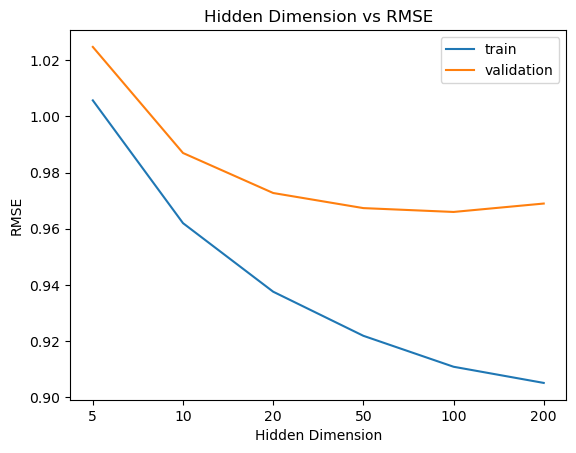

Optimal Hidden Dimension: 100 Optimal RMSE: 0.9659595379939592


In [35]:
plot(hidden_dims, "Hidden Dimension", trn_rmse, val_rmse)
optimal_hidden_dim = None
optimal_hidden_dim_rmse = None
for i in range(len(hidden_dims)):
    if optimal_hidden_dim is None or optimal_hidden_dim_rmse > val_rmse[i]:
        optimal_hidden_dim = hidden_dims[i]
        optimal_hidden_dim_rmse = val_rmse[i].item()
print("Optimal Hidden Dimension:", optimal_hidden_dim, "Optimal RMSE:", optimal_hidden_dim_rmse)

In [39]:
print(f"Optimal Hyperparameters:\n\t- Learning Rate: {optimal_lr}\n\t- Embedding Dimension: {optimal_emb_dim}\n\t- Hidden Dimension: {optimal_hidden_dim}\n\nOptimal RMSE: {min(optimal_lr_rmse, optimal_emb_dim_rmse, optimal_hidden_dim_rmse)}")

Optimal Hyperparameters:
	- Learning Rate: 0.1
	- Embedding Dimension: 100
	- Hidden Dimension: 100

Optimal RMSE: 0.9659595379939592


### **Answer3**

#### Change optimizer to AdamW, report best validation RMSE after tuning learning rate

Epoch: 19/20, Loss: 1.1666: 100%|██████████| 108/108 [00:01<00:00, 76.98it/s]


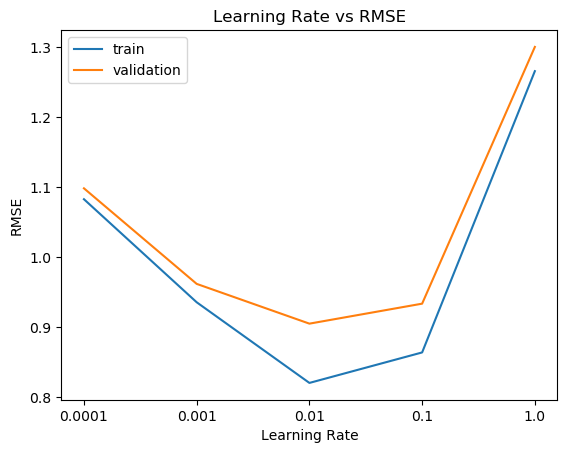

Optimal LR: 0.01 Optimal RMSE: 0.9053696681101441


In [12]:
def init_network_adam(num_users, num_movies, emb_dim=10, hidden_dim=100, lr=10e-3):
    net = Net(num_users, num_movies, emb_dim, hidden_dim)
    loss = nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    return net, loss, optimizer

lrs = [0.0001, 0.001, 0.01, 0.1, 1.0]
trn_rmse = []
val_rmse = []

for lr in lrs:
    net, loss_fn, optimizer = init_network_adam(num_users, num_movies, lr=lr)
    train(net, loss_fn, optimizer, trn_loader)
    trn_rmse.append(eval(net, trn_loader))
    val_rmse.append(eval(net, val_loader))
    
plot(lrs, "Learning Rate", trn_rmse, val_rmse)
optimal_lr = None
optimal_lr_rmse = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_lr_rmse > val_rmse[i]:
        optimal_lr = lrs[i]
        optimal_lr_rmse = val_rmse[i].item()
print("Optimal LR:", optimal_lr, "Optimal RMSE:", optimal_lr_rmse)

#### Tune `weight_decay` hyperparameter and report best validation RMSE

Epoch: 19/20, Loss: 0.8407: 100%|██████████| 108/108 [00:01<00:00, 76.00it/s]


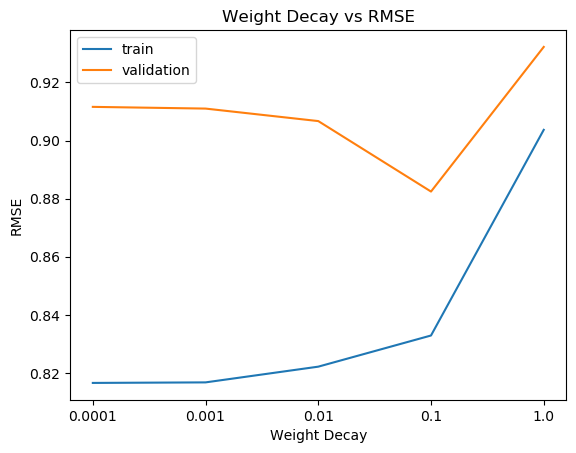

Optimal Weight Decay: 0.1 Optimal RMSE: 0.882440126848583


In [15]:
def init_network_adam(num_users, num_movies, weight_decay=0.01, emb_dim=10, hidden_dim=100, lr=10e-3):
    net = Net(num_users, num_movies, emb_dim, hidden_dim)
    loss = nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    return net, loss, optimizer

wds = [0.0001, 0.001, 0.01, 0.1, 1.0]
trn_rmse = []
val_rmse = []

for wd in wds:
    net, loss_fn, optimizer = init_network_adam(num_users, num_movies, lr=optimal_lr, weight_decay=wd)
    train(net, loss_fn, optimizer, trn_loader)
    trn_rmse.append(eval(net, trn_loader))
    val_rmse.append(eval(net, val_loader))
    
plot(wds, "Weight Decay", trn_rmse, val_rmse)
optimal_wd = None
optimal_wd_rmse = None
for i in range(len(wds)):
    if optimal_wd is None or optimal_wd_rmse > val_rmse[i]:
        optimal_wd = wds[i]
        optimal_wd_rmse = val_rmse[i].item()
print("Optimal Weight Decay:", optimal_wd, "Optimal RMSE:", optimal_wd_rmse)

#### Change loss formulation
Normalize your train rating matrix such that all ratings lie between $0$ and $1$ (i.e. divide the ratings by maximum rating which in this case is $5$). This allows us to treat this problem as a logistic regression problem as now we can pretend that the ratings are probability values (here the normalized rating values represents the probability of the movie being relevant to the user). Use binary cross entropy loss (`torch.nn.BinaryCrossEntropy`) to train the network (you'll need to use sigmoid activation instead of ReLU after the last layer and during testing you need to renormalize your predicted scores such that they are between $0$ to $5$ again)

In [25]:
class Net(nn.Module):
    def __init__(self, num_users, num_movies, emb_dim=10, hidden_dim=100):
        super().__init__()
        # TODO: define your network here
        self.emb_users = nn.Embedding(num_users, emb_dim)
        self.emb_movies = nn.Embedding(num_movies, emb_dim)
        self.fc = nn.Linear(2 * emb_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
        self.double()

    def forward(self, b):
        # TODO: define your forward pass here
        x = torch.cat([self.emb_users(b[0]), self.emb_movies(b[1])], dim=1)
        x = torch.tanh(self.fc(x))
        x = torch.sigmoid(self.linear(x))
        return x.squeeze()

def eval(net, loader):
    net.eval()
    with torch.no_grad():
        se = 0
        for b in loader:
            y = 5 * net(b)
            se += F.mse_loss(y.squeeze(), b[2].float(), reduction='sum').item()
        rmse = np.sqrt(se/loader.dataset.n)
    return rmse

def init_network_adam_bce(num_users, num_movies, weight_decay=0.01, emb_dim=10, hidden_dim=100, lr=10e-3):
    net = Net(num_users, num_movies, emb_dim, hidden_dim)
    loss = nn.BCELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    return net, loss, optimizer

normalized_trn_R = trn_R / 5
normalized_trn_dataset = Dataset(normalized_trn_R)
normalized_trn_loader = torch.utils.data.DataLoader(normalized_trn_dataset, batch_size=2048, shuffle=True)
net, loss_fn, optimizer = init_network_adam_bce(num_users, num_movies, lr=optimal_lr, weight_decay=optimal_wd)
train(net, loss_fn, optimizer, normalized_trn_loader)
trn_rmse = eval(net, trn_loader)
val_rmse = eval(net, val_loader)
print(f'Training Data RMSE: {trn_rmse}, Validation Data RMSE: {val_rmse}')

Epoch: 19/20, Loss: 0.5665: 100%|██████████| 108/108 [00:03<00:00, 35.19it/s]


Training Data RMSE: 0.8095481080846219, Validation Data RMSE: 0.8847539645614881
